In [1]:
# Core libraries
import os, wave, numpy as np, pandas as pd, seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Audio
import librosa, librosa.display
import resampy   

# Deep-learning stack  (needs: pip install tensorflow)
import tensorflow as tf, pydot
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
    Conv1D, Conv2D, SeparableConv1D, MaxPooling1D, MaxPooling2D,
    Input, add, Flatten, Dense, BatchNormalization, Dropout,
    LSTM, GRU, GlobalMaxPooling1D, GlobalMaxPooling2D,
    Activation, LeakyReLU, ReLU, concatenate
)
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import regularizers, backend as K
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Classic ML helpers
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, cohen_kappa_score, roc_auc_score,
    confusion_matrix, classification_report
)
print(" All imports succeeded")


 All imports succeeded


In [2]:
BASE_DIR  = "respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database"
AUDIO_DIR = f"{BASE_DIR}/audio_and_txt_files"
CSV_PATH  = f"{BASE_DIR}/patient_diagnosis.csv"
#print("audio dir exists:", os.path.exists(AUDIO_DIR))
#print("CSV exists:",      os.path.isfile(CSV_PATH))


In [3]:
csv_path = (
    "respiratory-sound-database/"
    "Respiratory_Sound_Database/"
    "Respiratory_Sound_Database/"
    "patient_diagnosis.csv"
)



In [4]:
diagnosis_df = pd.read_csv(csv_path, names=["patient_id", "disease"])
diagnosis_df.head(4)

,patient_id,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD


In [5]:
print (diagnosis_df.disease.value_counts())
print ('')
print (diagnosis_df.disease.value_counts(normalize=True) *100)

disease
COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Bronchiolitis      6
Pneumonia          6
LRTI               2
Asthma             1
Name: count, dtype: int64

disease
COPD              50.793651
Healthy           20.634921
URTI              11.111111
Bronchiectasis     5.555556
Bronchiolitis      4.761905
Pneumonia          4.761905
LRTI               1.587302
Asthma             0.793651
Name: proportion, dtype: float64


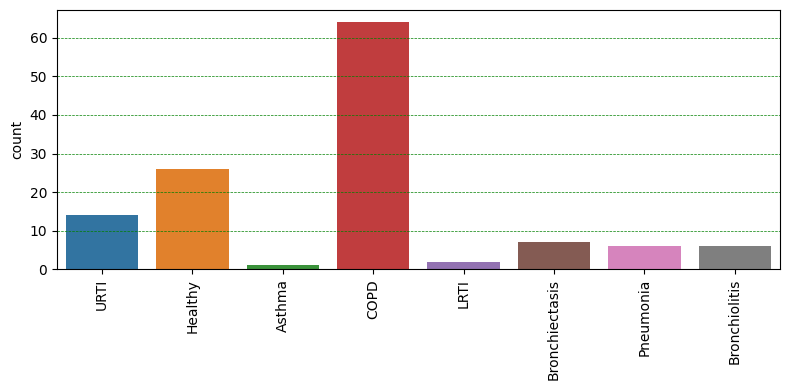

In [6]:
plt.figure(figsize=(8,4))

# Workaround: pass the same column to both x and hue, then drop the legend.
sns.countplot(
    data=diagnosis_df,
    x="disease",
    hue="disease",          # satisfies Seaborn ≥0.14
    palette="tab10",
    legend=False
)

plt.grid(axis="y", color="green", linestyle="--", linewidth=0.5)
plt.xlabel("")              # remove default x-label
plt.ylabel("count")
plt.xticks(rotation=90)      # upright labels
plt.tight_layout()
plt.show()

In [7]:
path = (
    "respiratory-sound-database/"
    "Respiratory_Sound_Database/"
    "Respiratory_Sound_Database/"
    "audio_and_txt_files"
)

files = [s.rsplit(".", 1)[0]          
         for s in os.listdir(path)
         if s.endswith(".txt")]        
print(len(files), " files found")                            


920  files found


In [8]:
files[:10]

['101_1b1_Al_sc_Meditron',
 '101_1b1_Pr_sc_Meditron',
 '102_1b1_Ar_sc_Meditron',
 '103_2b2_Ar_mc_LittC2SE',
 '104_1b1_Al_sc_Litt3200',
 '104_1b1_Ar_sc_Litt3200',
 '104_1b1_Ll_sc_Litt3200',
 '104_1b1_Lr_sc_Litt3200',
 '104_1b1_Pl_sc_Litt3200',
 '104_1b1_Pr_sc_Litt3200']

In [9]:
def add_noise(data, factor: float = 0.005):

    noise = np.random.randn(len(data))
    return data + factor * noise

def shift(data, steps: int):

    return np.roll(data, steps)

def stretch(data, rate: float):

    return librosa.effects.time_stretch(data, rate=rate)  

def pitch_shift(data, n_steps: int, sr: int = 22_050):

    return librosa.effects.pitch_shift(data, sr=sr, n_steps=n_steps)

In [10]:
def show_audio(audio_path):

    y, sr = librosa.load(audio_path)

    y_noise        = add_noise(y, 0.0008)
    y_shift        = shift(y, 3_200)
    y_stretch_fast = stretch(y, 1.2)
    y_stretch_slow = stretch(y, 0.8)
    y_pitch_shift  = pitch_shift(y, 3, sr=sr)

    plt.figure(figsize=(20, 8))

    plt.subplot(3, 2, 1); librosa.display.waveshow(y,               sr=sr); plt.title("original")
    plt.subplot(3, 2, 2); librosa.display.waveshow(y_noise,        sr=sr); plt.title("noise")
    plt.subplot(3, 2, 3); librosa.display.waveshow(y_shift,        sr=sr); plt.title("shift")
    plt.subplot(3, 2, 4); librosa.display.waveshow(y_stretch_fast, sr=sr); plt.title("stretch ×1.2")
    plt.subplot(3, 2, 5); librosa.display.waveshow(y_stretch_slow, sr=sr); plt.title("stretch ×0.8")
    plt.subplot(3, 2, 6); librosa.display.waveshow(y_pitch_shift,  sr=sr); plt.title("pitch +3 st")

    plt.tight_layout()
    plt.show()


In [11]:
def show_audio_features(audio_path):
    y, sr = librosa.load(audio_path)

    aug = {
        "original"   : y,
        "noise"      : add_noise(y, 0.0008),
        "shift"      : shift(y, 3_200),
        "stretch ×1.2": stretch(y, 1.2),
        "stretch ×0.8": stretch(y, 0.8),
        "pitch +3 st": pitch_shift(y, 3, sr=sr),
    }

    plt.figure(figsize=(20, 8))
    for idx, (label, signal) in enumerate(aug.items(), start=1):
        mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=52)
        plt.subplot(3, 2, idx)
        librosa.display.specshow(
            librosa.power_to_db(mfcc, ref=np.max),
            y_axis="mel", fmax=8_000, x_axis="time"
        )
        plt.colorbar(format="%+2.0f dB")
        plt.title(label)

    plt.tight_layout()
    plt.show()

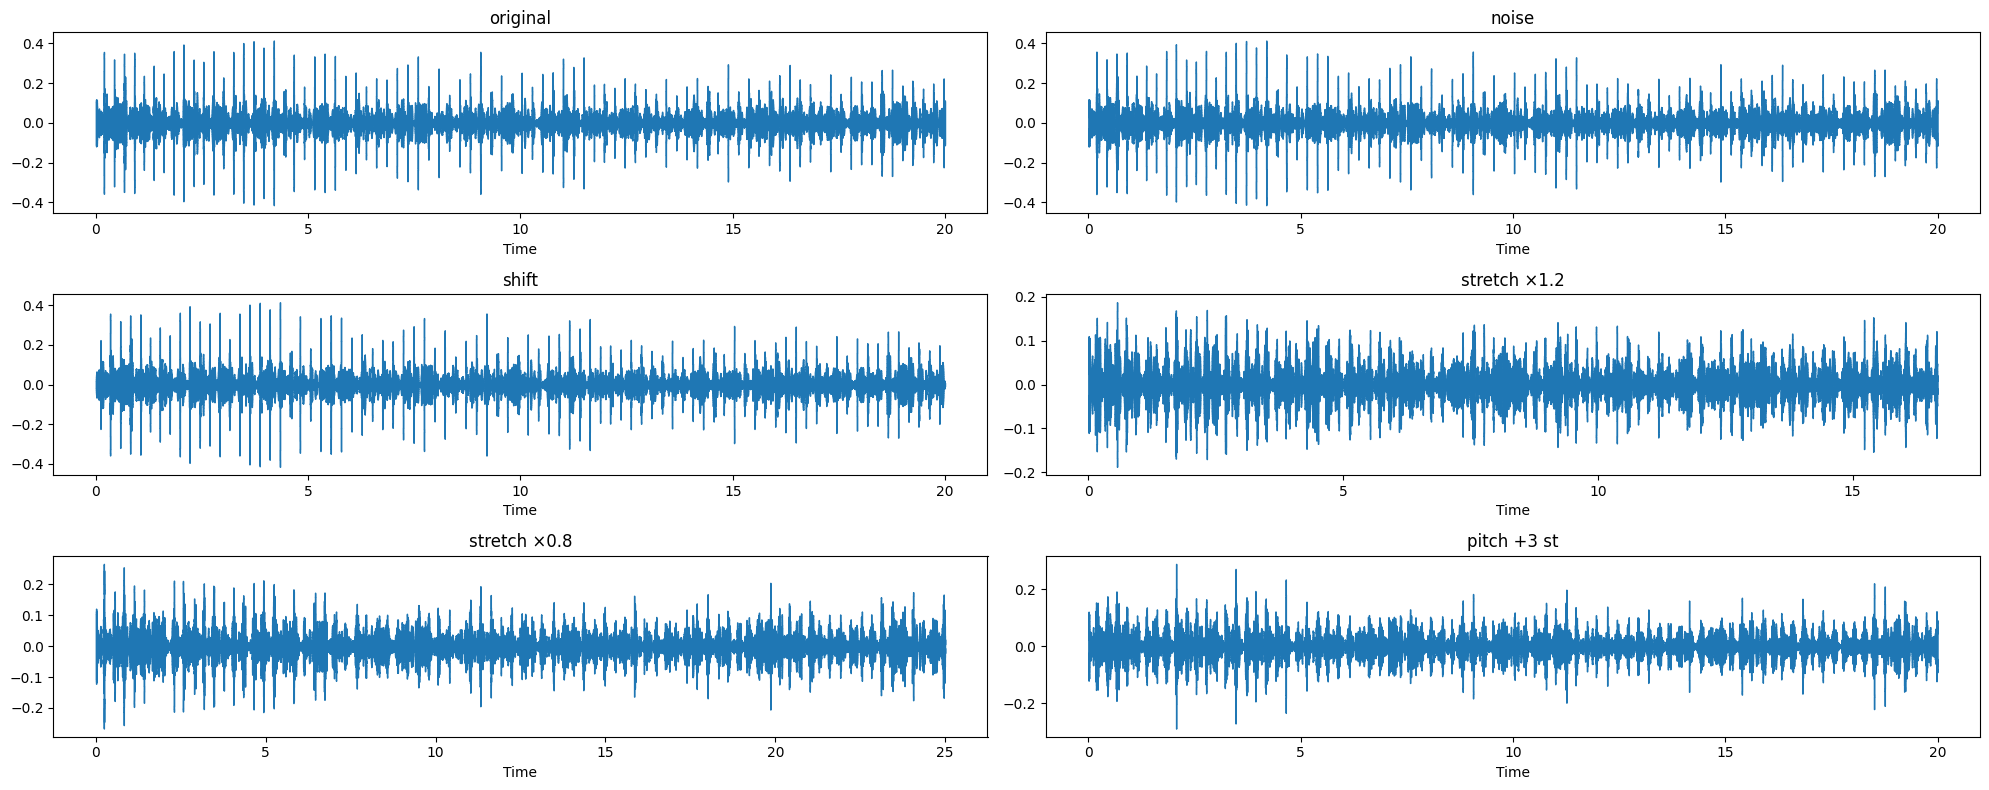

In [12]:
show_audio(
    "respiratory-sound-database/Respiratory_Sound_Database/"
    "Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.wav"
)


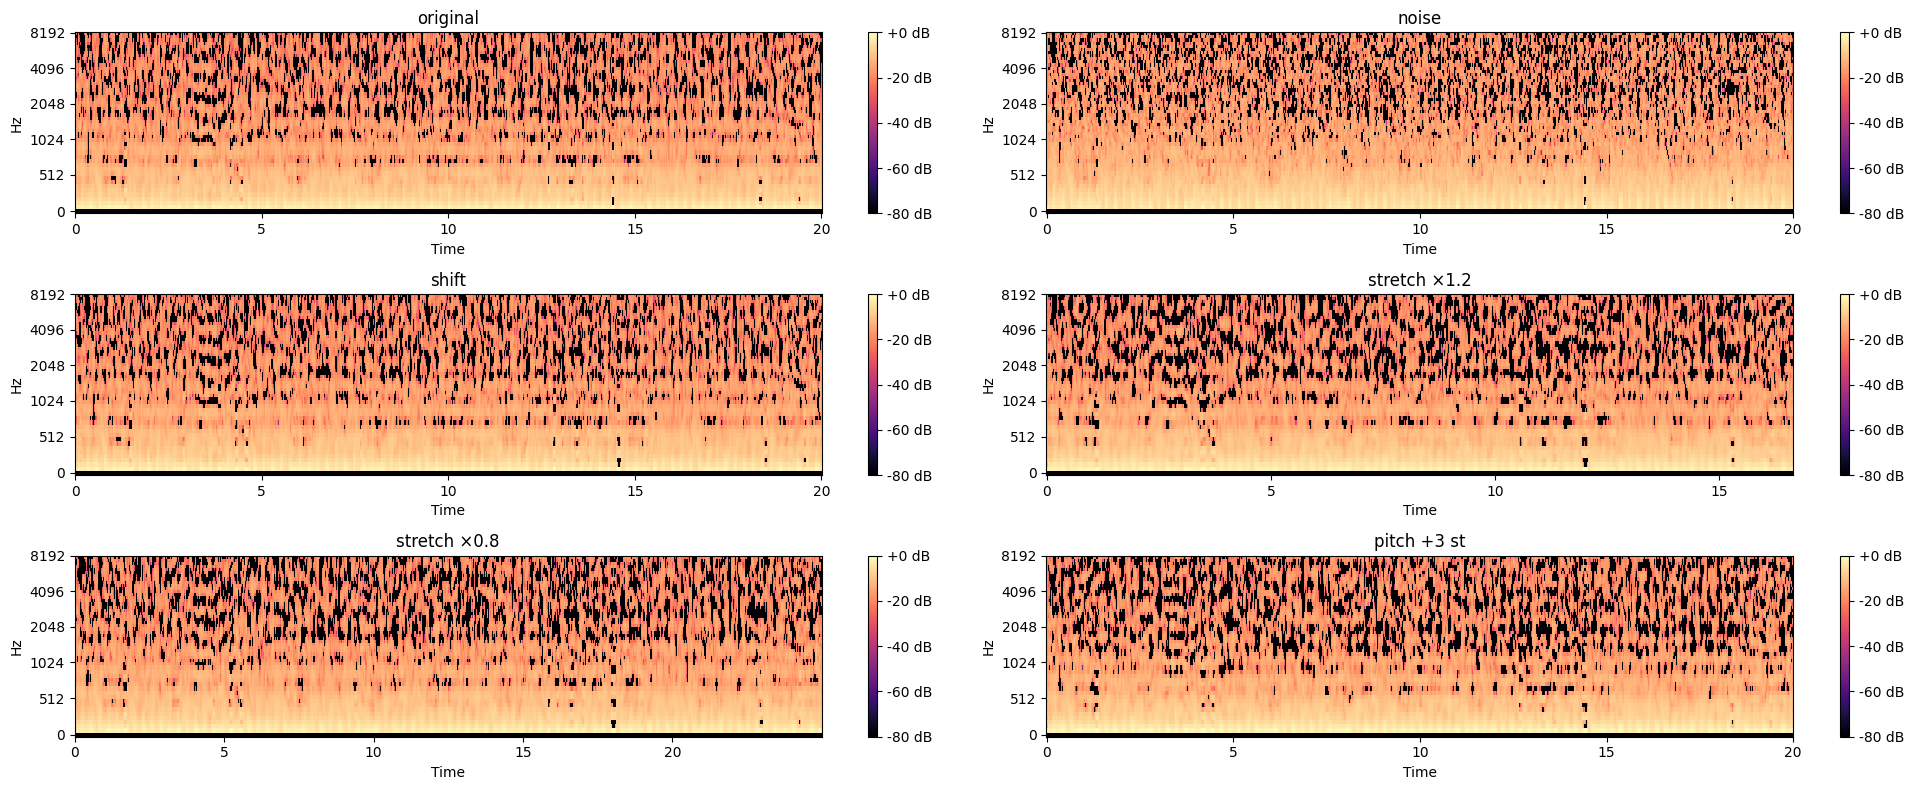

In [13]:
show_audio_features(
    "respiratory-sound-database/Respiratory_Sound_Database/"
    "Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.wav"
)


In [14]:

def mfccs_feature_exteraction(audio_dir: str):
    """
    Return X  (n_samples, 52) and y  (n_samples,) for all .wav files in `audio_dir`.
    • 50 MFCCs averaged over time  → 50-D vector
    • +2 Mel-spec extras after pitch-shift (same as before)
    • Skips patients 103, 108, 115
    • Down-samples COPD (≤2 recordings per visit)
    """
    X, y = [], []
    seen_copd, copd_count = set(), 0

    for fname in os.listdir(audio_dir):
        if not fname.endswith(".wav") or fname[:3] in {"103", "108", "115"}:
            continue

        pid   = int(fname[:3])
        label = diagnosis_df.loc[diagnosis_df.patient_id == pid,
                                 "disease"].values[0]

        wav, sr = librosa.load(os.path.join(audio_dir, fname),
                               res_type="kaiser_fast")

        def _push(vec, lab):           # helper to append one sample
            X.append(vec); y.append(lab)

        # 50-D MFCC of the original signal
        mfcc = np.mean(librosa.feature.mfcc(y=wav, sr=sr,
                                            n_mfcc=52).T, axis=0)

        # ---------- class-specific handling ----------
        if label == "COPD":
            visit = fname[:6]                       # e.g. 101_1b
            if visit in seen_copd and copd_count < 2:
                _push(mfcc, label); copd_count += 1
            elif visit not in seen_copd:
                seen_copd.add(visit); copd_count = 0
                _push(mfcc, label)

        else:
            base = "Bronchiolitis" if label in {"Bronchiectasis",
                                                "Bronchiolitis"} else label
            _push(mfcc, base)

            # five augmentations
            for sig in (
                add_noise(wav, 0.001),
                shift(wav, 1_600),
                stretch(wav, 1.2),
                stretch(wav, 0.8),
                pitch_shift(wav, 3, sr),
            ):
                feat = np.mean(librosa.feature.mfcc(y=sig, sr=sr,
                                                    n_mfcc=52).T, axis=0)
                _push(feat, base)

    return np.array(X), np.array(y)


In [15]:
x_mfccs, y = mfccs_feature_exteraction(AUDIO_DIR)

In [16]:
def augmented_lables_count(lables):
    unique, counts = np.unique(lables, return_counts=True)
    data_count = dict(zip(unique, counts))

    data = data_count

    courses = list(data.keys())
    values = list(data.values())

    fig = plt.figure(figsize = (10, 5))

    # creating the bar plot
    plt.bar(courses, values, color =['orange','green','blue','red','yellow','black'],
            width = 0.4)

    plt.xlabel("Diseases")
    plt.ylabel("Count")
    plt.title("Count of each disease")
    plt.show()

    print (data_count)

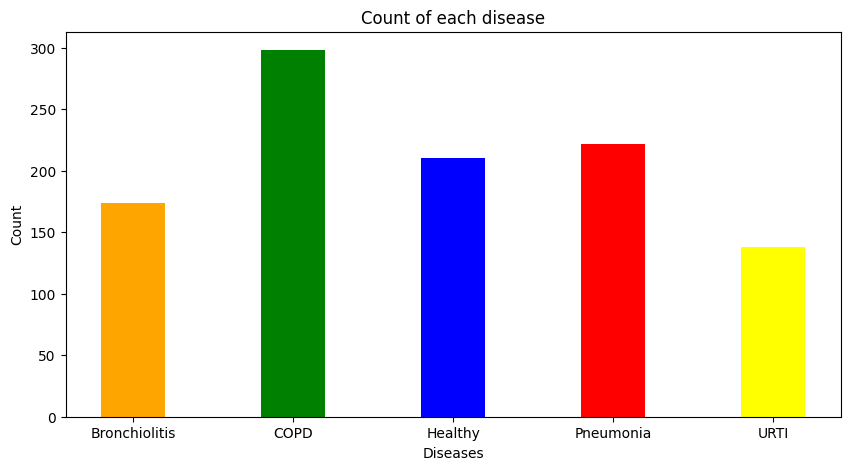

{np.str_('Bronchiolitis'): np.int64(174), np.str_('COPD'): np.int64(298), np.str_('Healthy'): np.int64(210), np.str_('Pneumonia'): np.int64(222), np.str_('URTI'): np.int64(138)}


In [17]:
augmented_lables_count(y)

In [18]:
y_data_encode = y.reshape(y.shape[0],1)
y_data_encode = np.where(y_data_encode == 'COPD',np.array([1,0,0,0,0]).reshape(1,5) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'Bronchiolitis',np.array([0,1,0,0,0]).reshape(1,5) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'Pneumonia',np.array([0,0,1,0,0]).reshape(1,5) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'URTI',np.array([0,0,0,1,0]).reshape(1,5) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'Healthy',np.array([0,0,0,0,1]).reshape(1,5) , y_data_encode)

Y_data = y_data_encode.astype('float64')

In [19]:
mfccs_features = np.array(x_mfccs)
lables = np.array(Y_data)

mfccs_features.shape , lables.shape

((1042, 52), (1042, 5))

In [20]:
mfcc_train, mfcc_val, lables_train, lables_val  = train_test_split(mfccs_features, lables, test_size=0.175, random_state=10)
mfcc_train, mfcc_test, lables_train, lables_test = train_test_split(mfcc_train, lables_train, test_size=0.075, random_state=10)

print (mfcc_train.shape, mfcc_val.shape, mfcc_test.shape)
print (lables_train.shape, lables_val.shape, lables_test.shape)

(794, 52) (183, 52) (65, 52)
(794, 5) (183, 5) (65, 5)


In [21]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
#   plt.plot(epochs, loss, label='training_loss')
#   plt.plot(epochs, val_loss, label='val_loss')
#   plt.title('Loss')
#   plt.xlabel('Epochs')
#   plt.legend()
#   plt.grid()


  # Plot accuracy
  plt.figure()
  plt.grid()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();


In [22]:
x_train_gru = np.expand_dims(mfcc_train,axis=1)
x_val_gru = np.expand_dims(mfcc_val,axis=1)
x_test_gru = np.expand_dims(mfcc_test,axis=1)

y_train_gru = np.expand_dims(lables_train,axis=1)
y_val_gru = np.expand_dims(lables_val,axis=1)
y_test_gru = np.expand_dims(lables_test,axis=1)

In [23]:
Input_Sample = Input(shape=(1,52))

model_conv = Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(Input_Sample)
model_conv = MaxPooling1D(pool_size=2, strides = 2, padding = 'same')(model_conv)
model_conv = BatchNormalization()(model_conv)

model_conv = Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu')(model_conv)
model_conv = MaxPooling1D(pool_size=2, strides = 2, padding = 'same')(model_conv)
model_conv = BatchNormalization()(model_conv)

model_2_1 = GRU(32,return_sequences=True,activation='tanh',go_backwards=True)(model_conv)
model_2 = GRU(128,return_sequences=True, activation='tanh',go_backwards=True)(model_2_1)

model_3 = GRU(64,return_sequences=True,activation='tanh',go_backwards=True)(model_conv)
model_3 = GRU(128,return_sequences=True, activation='tanh',go_backwards=True)(model_3)

model_x = GRU(64,return_sequences=True,activation='tanh',go_backwards=True)(model_conv)
model_x = GRU(128,return_sequences=True, activation='tanh',go_backwards=True)(model_x)

model_add_1 = add([model_3,model_2,model_x])

model_5 = GRU(128,return_sequences=True,activation='tanh',go_backwards=True)(model_add_1)
model_5 = GRU(32,return_sequences=True, activation='tanh',go_backwards=True)(model_5)

model_6 = GRU(64,return_sequences=True,activation='tanh',go_backwards=True)(model_add_1)
model_6 = GRU(32,return_sequences=True, activation='tanh',go_backwards=True)(model_6)

model_add_2 = add([model_5,model_6,model_2_1])


model_7 = Dense(32, activation=None)(model_add_2)
model_7 = LeakyReLU()(model_7)
model_7 = Dense(128, activation=None)(model_7)
model_7 = LeakyReLU()(model_7)

model_9 = Dense(64, activation=None)(model_add_2)
model_9 = LeakyReLU()(model_9)
model_9 = Dense(128, activation=None)(model_9)
model_9 = LeakyReLU()(model_9)

model_add_3 = add([model_7,model_9])

model_10 = Dense(64, activation=None)(model_add_3)
model_10 = LeakyReLU()(model_10)

model_10 = Dense(32, activation=None)(model_10)
model_10 = LeakyReLU()(model_10)

model_10 = Dense(5, activation="softmax")(model_10)

gru_model = Model(inputs=Input_Sample, outputs = model_10)

gru_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 1, 52)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d (Conv1D)               │ (None, 1, 256)            │          66,816 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d (MaxPooling1D)  │ (None, 1, 256)            │               0 │ conv1d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 1, 256)            │           1,024 │ max_pooling1d[0][0]        │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_1 (Conv1D)             │ (None, 1, 512)            │         655,872 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_1               │ (None, 1, 512)            │               0 │ conv1d_1[0][0]             │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 1, 512)            │           2,048 │ max_pooling1d_1[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gru_2 (GRU)                   │ (None, 1, 64)             │         110,976 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gru (GRU)                     │ (None, 1, 32)             │          52,416 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gru_4 (GRU)                   │ (None, 1, 64)             │         110,976 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gru_3 (GRU)                   │ (None, 1, 128)            │          74,496 │ gru_2[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gru_1 (GRU)                   │ (None, 1, 128)            │          62,208 │ gru[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gru_5 (GRU)                   │ (None, 1, 128)            │          74,496 │ gru_4[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 1, 128)            │               0 │ gru_3[0][0], gru_1[0][0],  │
│                               │                           │                 │ gru_5[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gru_6 (GRU)                   │ (None, 1, 128)            │          99,072 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 1,398,821 (5.34 MB)

 Trainable params: 1,397,285 (5.33 MB)

 Non-trainable params: 1,536 (6.00 KB)

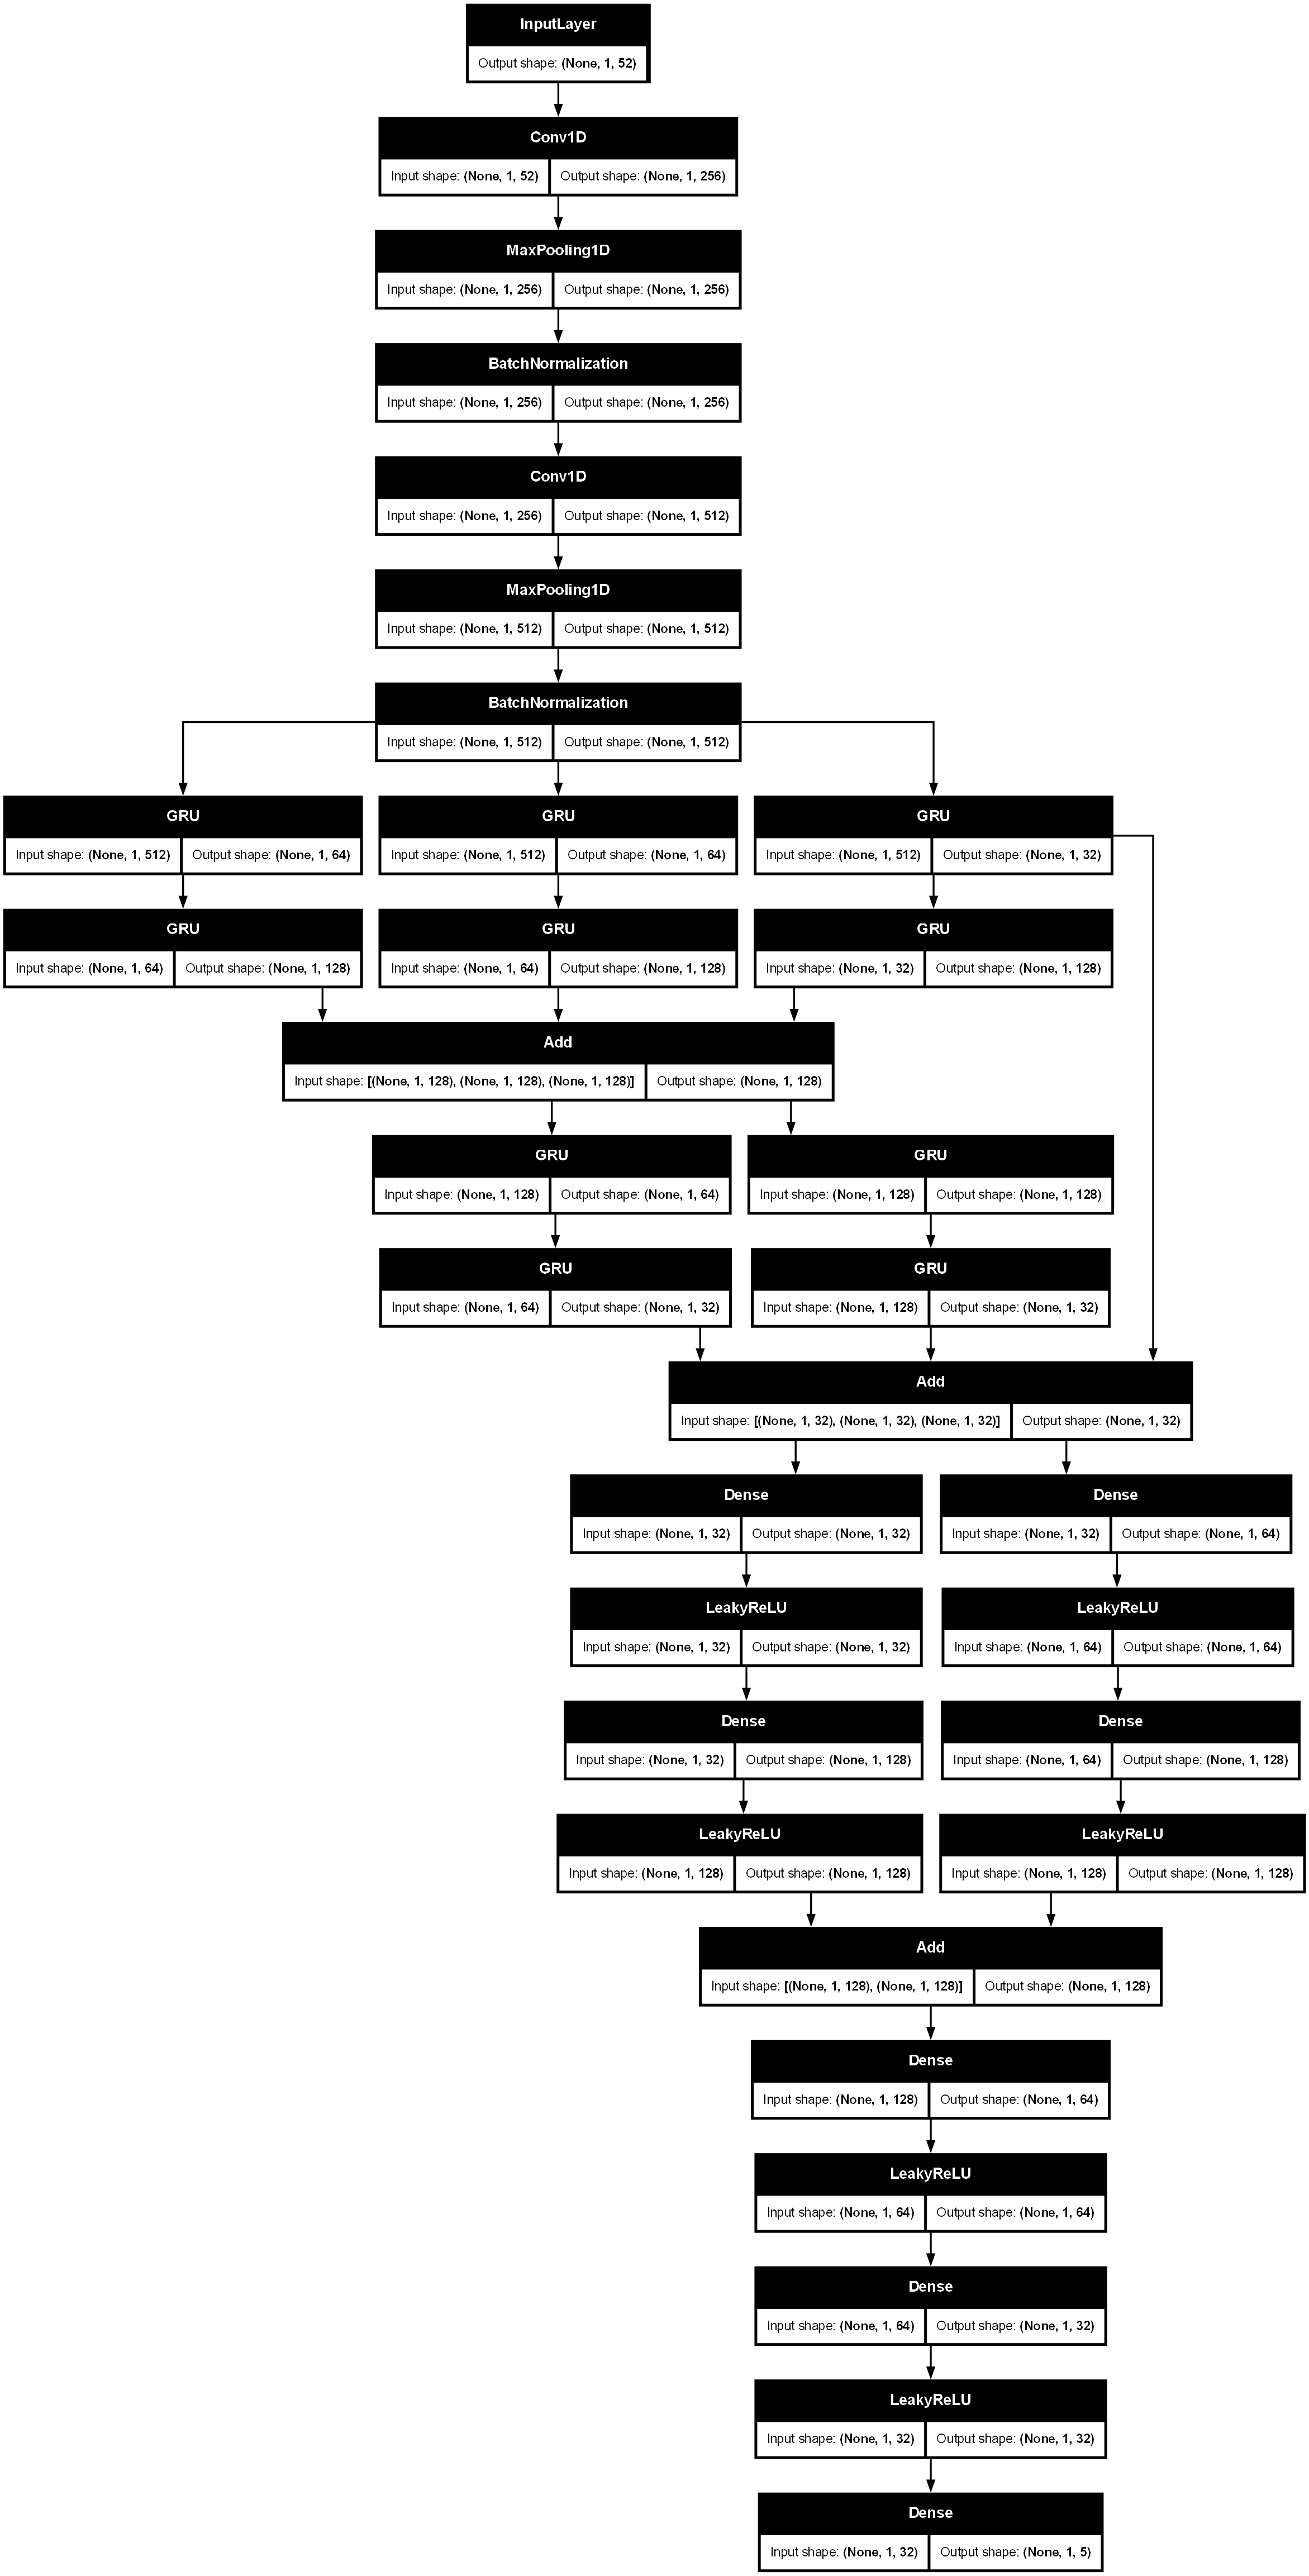

In [24]:
tf.keras.utils.plot_model(gru_model,
                          to_file="gru_model.png",
                          show_shapes=True,
                          dpi=120)


In [25]:
optimiser = tf.keras.optimizers.Adam(learning_rate = 0.0001)
gru_model.compile(optimizer=optimiser, loss='categorical_crossentropy',metrics=['accuracy'])

cb = [EarlyStopping(patience=300,monitor='accuracy',mode='max',restore_best_weights=True),
      ModelCheckpoint("/kaggle/working/diagnosis_GRU_CNN_1.h5",save_best_only=True)]

In [26]:
history = gru_model.fit(x_train_gru, y_train_gru, batch_size=8, epochs=50, validation_data=(x_val_gru, y_val_gru), callbacks = cb)

Epoch 1/50
 98/100 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3878 - loss: 1.4282

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.4534 - loss: 1.3462 - val_accuracy: 0.3880 - val_loss: 1.5090
Epoch 2/50
 97/100 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5447 - loss: 1.1531

100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5441 - loss: 1.1490 - val_accuracy: 0.5628 - val_loss: 1.1895
Epoch 3/50
 98/100 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6006 - loss: 1.0052

100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6071 - loss: 1.0073 - val_accuracy: 0.6667 - val_loss: 0.9435
Epoch 4/50
 98/100 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6764 - loss: 0.8805

100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6511 - loss: 0.9158 - val_accuracy: 0.6393 - val_loss: 0.8711
Epoch 5/50
 98/100 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6773 - loss: 0.8535

100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6914 - loss: 0.8361 - val_accuracy: 0.6885 - val_loss: 0.7948
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7330 - loss: 0.7364

100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7154 - loss: 0.7620 - val_accuracy: 0.7432 - val_loss: 0.7098
Epoch 7/50
 97/100 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7094 - loss: 0.7531

100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7154 - loss: 0.7415 - val_accuracy: 0.7432 - val_loss: 0.6707
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7018 - loss: 0.7942

100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7229 - loss: 0.7439 - val_accuracy: 0.7268 - val_loss: 0.6243
Epoch 9/50
 97/100 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7267 - loss: 0.7130

100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7179 - loss: 0.7304 - val_accuracy: 0.7596 - val_loss: 0.5880
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7431 - loss: 0.6678 - val_accuracy: 0.7650 - val_loss: 0.6292
Epoch 11/50
 98/100 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7624 - loss: 0.6286

100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7531 - loss: 0.6516 - val_accuracy: 0.7814 - val_loss: 0.5645
Epoch 12/50
 97/100 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7680 - loss: 0.6328

100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7569 - loss: 0.6575 - val_accuracy: 0.8197 - val_loss: 0.4608
Epoch 13/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7632 - loss: 0.6170 - val_accuracy: 0.8142 - val_loss: 0.5055
Epoch 14/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8023 - loss: 0.5552 - val_accuracy: 0.7978 - val_loss: 0.4764
Epoch 15/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7758 - loss: 0.5936 - val_accuracy: 0.7650 - val_loss: 0.5849
Epoch 16/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7708 - loss: 0.6114 - val_accuracy: 0.7432 - val_loss: 0.6133
Epoch 17/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7947 - loss: 0.5474 - val_accuracy: 0.8142 - val_loss: 0.5047
Epoch 18/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7683 - loss: 0.6003 - val_accuracy: 0.7978 - val_loss: 0.5068
Epoch 19/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7884 - loss: 0.5488 - val_accuracy

100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8199 - loss: 0.5088 - val_accuracy: 0.8197 - val_loss: 0.4391
Epoch 21/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8086 - loss: 0.5133 - val_accuracy: 0.8087 - val_loss: 0.4627
Epoch 22/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7997 - loss: 0.4820 - val_accuracy: 0.8142 - val_loss: 0.4711
Epoch 23/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8098 - loss: 0.4856 - val_accuracy: 0.7978 - val_loss: 0.4749
Epoch 24/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8325 - loss: 0.4422 - val_accuracy: 0.8197 - val_loss: 0.4482
Epoch 25/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8363 - loss: 0.4358 - val_accuracy: 0.7978 - val_loss: 0.5331
Epoch 26/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8287 - loss: 0.4774 - val_accuracy: 0.8525 - val_loss: 0.4718
Epoch 27/50
 97/100 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8565 - loss: 0.4326

100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8401 - loss: 0.4240 - val_accuracy: 0.8689 - val_loss: 0.4031
Epoch 28/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8350 - loss: 0.4337 - val_accuracy: 0.8033 - val_loss: 0.4859
Epoch 29/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8102 - loss: 0.4522

100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8476 - loss: 0.4078 - val_accuracy: 0.8579 - val_loss: 0.3904
Epoch 30/50
 97/100 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8632 - loss: 0.3685

100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8564 - loss: 0.3928 - val_accuracy: 0.8907 - val_loss: 0.3539
Epoch 31/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8640 - loss: 0.3743 - val_accuracy: 0.8579 - val_loss: 0.3930
Epoch 32/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8401 - loss: 0.4220 - val_accuracy: 0.8415 - val_loss: 0.4580
Epoch 33/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8451 - loss: 0.4374 - val_accuracy: 0.8470 - val_loss: 0.4076
Epoch 34/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8564 - loss: 0.3934 - val_accuracy: 0.8470 - val_loss: 0.4679
Epoch 35/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8753 - loss: 0.3520 - val_accuracy: 0.8689 - val_loss: 0.4016
Epoch 36/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8665 - loss: 0.3559 - val_accuracy: 0.8470 - val_loss: 0.4992
Epoch 37/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8426 - loss: 0.3860 - val_accuracy

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9673 - loss: 0.1266


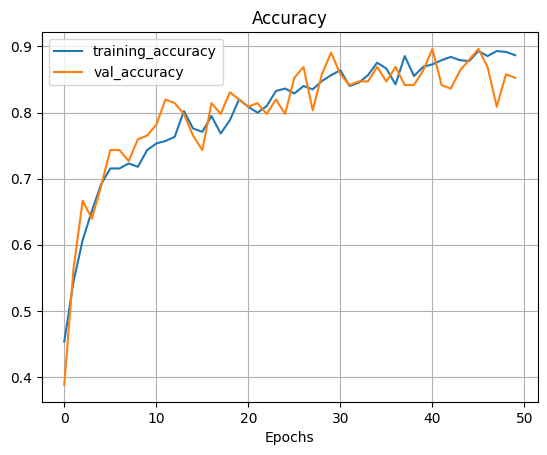

In [27]:
gru_model.evaluate(x_train_gru, y_train_gru)

plot_loss_curves(history)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 794ms/step


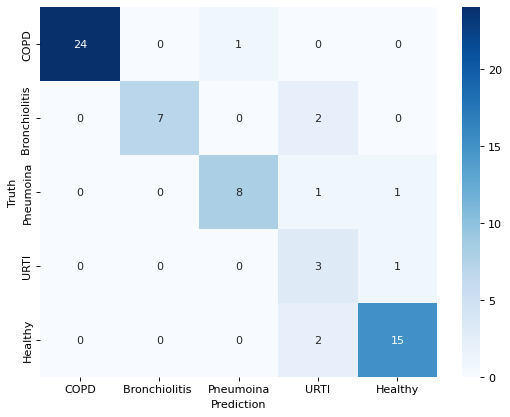

In [28]:
classes = ["COPD" ,"Bronchiolitis ", "Pneumoina", "URTI", "Healthy"]

preds = gru_model.predict(x_test_gru)
classpreds = [np.argmax(t) for t in preds ]
y_testclass = [np.argmax(t) for t in y_test_gru]
cm = confusion_matrix(y_testclass, classpreds)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

plt.title('')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [29]:
print(classification_report(y_testclass, classpreds, target_names=classes))

                precision    recall  f1-score   support

          COPD       1.00      0.96      0.98        25
Bronchiolitis        1.00      0.78      0.88         9
     Pneumoina       0.89      0.80      0.84        10
          URTI       0.38      0.75      0.50         4
       Healthy       0.88      0.88      0.88        17

      accuracy                           0.88        65
     macro avg       0.83      0.83      0.82        65
  weighted avg       0.91      0.88      0.89        65



In [30]:
def gru_diagnosis_prediction(test_audio):
    data_x, sampling_rate = librosa.load(test_audio)
    data_x = stretch (data_x,1.2)

    features = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=52).T,axis = 0)

    features = features.reshape(1,52)

    test_pred = gru_model.predict(np.expand_dims(features, axis = 1))
    classpreds = classes[np.argmax(test_pred[0], axis=1)[0]]
    confidence = test_pred.T[test_pred[0].mean(axis=0).argmax()].mean()

    print (classpreds , confidence)

In [31]:

wav_name  = "107_2b5_Ar_mc_AKGC417L.wav"                    
wav_path  = os.path.join(AUDIO_DIR, wav_name)

n_mfcc = 52
signal, sr = librosa.load(wav_path, sr=None, res_type="kaiser_fast")
mfcc_mean = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc).mean(axis=1)

val = np.expand_dims(mfcc_mean, axis=0)   # (1, 52)
val = np.expand_dims(val,        axis=1)  # (1, 1, 52)

print("Loaded:", wav_path)
print("val.shape:", val.shape)


Loaded: respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files\107_2b5_Ar_mc_AKGC417L.wav
val.shape: (1, 1, 52)


In [32]:
classes[np.argmax(gru_model.predict(val))]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


'COPD'

In [33]:
import pickle

# After training your model, save it
pickle.dump(gru_model, open('gru_model.pkl', 'wb'))
